In [16]:
import numpy as np
from Bio import SeqIO

np.random.seed(0)

nucleotides = ['A', 'T', 'G', 'C']

sequence_string = ''.join(np.random.choice(nucleotides, 1000).tolist())
reads = ''

for i in range(1, 1001):
    read_len = 150
    read_start = np.random.default_rng().integers(0, 1000 - read_len)
    read_str = sequence_string[read_start:read_start+read_len]
    reads += f'>READ_SEQ_{i}\n{read_str}\n'

with open(f"reads.fasta", "w") as file:
    file.write(reads)

with open("sequense.fasta", "w") as file:
    file.write('>MAIN_SEQ_0\n')
    file.write(sequence_string)

## Построение графа Де Брюина
По заданному набору ридов в формате FASTQ и параметру k, который соответствует длине k-меров, построить граф Де Брюина, некоторый путь в котором соответствовал бы возможной подстроке в исходном геноме. Не забывайте про запоминание покрытия каждого k-мера, а так же про сами подстроки, которые соответствуют каждому ребру. В остальном граф полностью соответствует тому, что был описан в лекции.

In [3]:
import numpy as np
from Bio import SeqIO

seq_name, seq_string = [], []
with open ("/home/pk/Desktop/BOTAY/BioinformaticsCourse2024PK/homework/2_2/reads.fasta",'r') as fa:
    for seq_record  in SeqIO.parse(fa,'fasta'):
        seq_name.append(str(seq_record.name))
        seq_string.append(str(seq_record.seq))

true_seq_name, true_seq_string = [], []
with open ("/home/pk/Desktop/BOTAY/BioinformaticsCourse2024PK/homework/2_2/sequense.fasta",'r') as fa:
    for seq_record  in SeqIO.parse(fa,'fasta'):
        true_seq_name.append(str(seq_record.name))
        true_seq_string.append(str(seq_record.seq))
true_seq = true_seq_string[0]

AGATGAATGGACCGGCCATATAAGT
AGATGAATGGACCGGCCATATAAGT



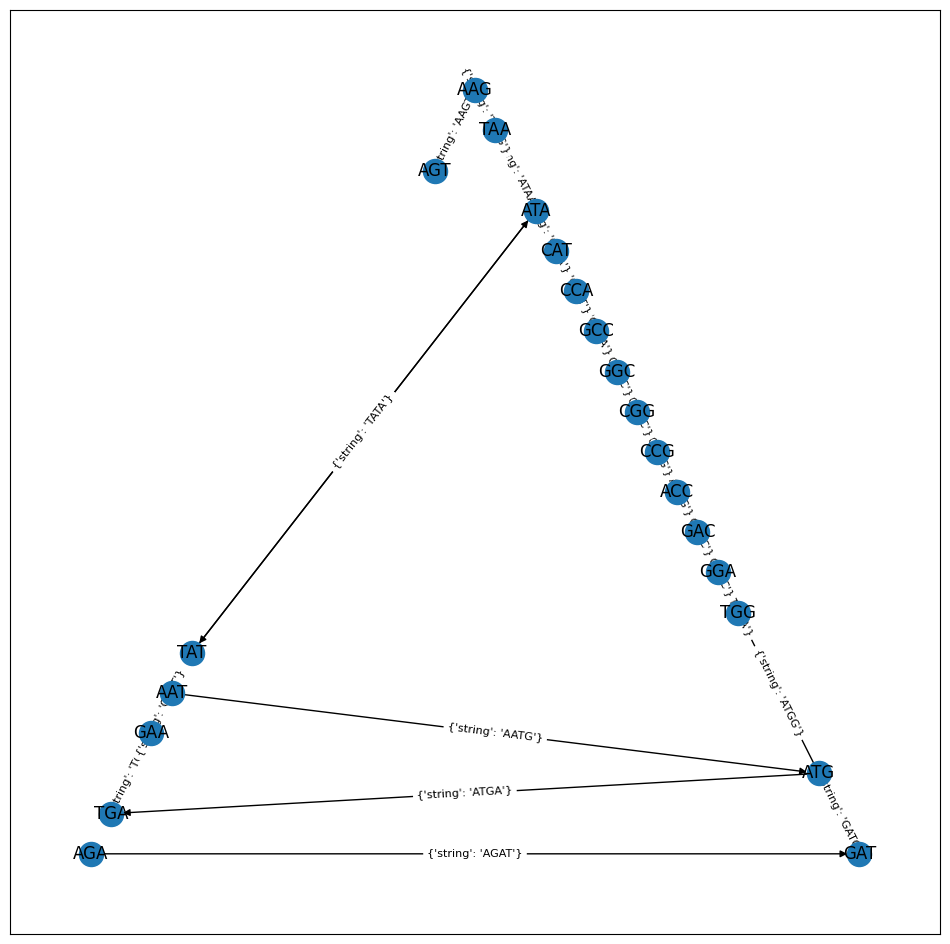

AGA

ATG
[<__main__.Edge object at 0x77ad74ce2a50>, <__main__.Edge object at 0x77ad74da3fb0>]

TGG

ATA
[<__main__.Edge object at 0x77ad7436af00>, <__main__.Edge object at 0x77ad74da2540>]

TAA

AGATGAATGGACCGGCCATATAAGT
AGATGAATGGACCGGCCATATAAGT


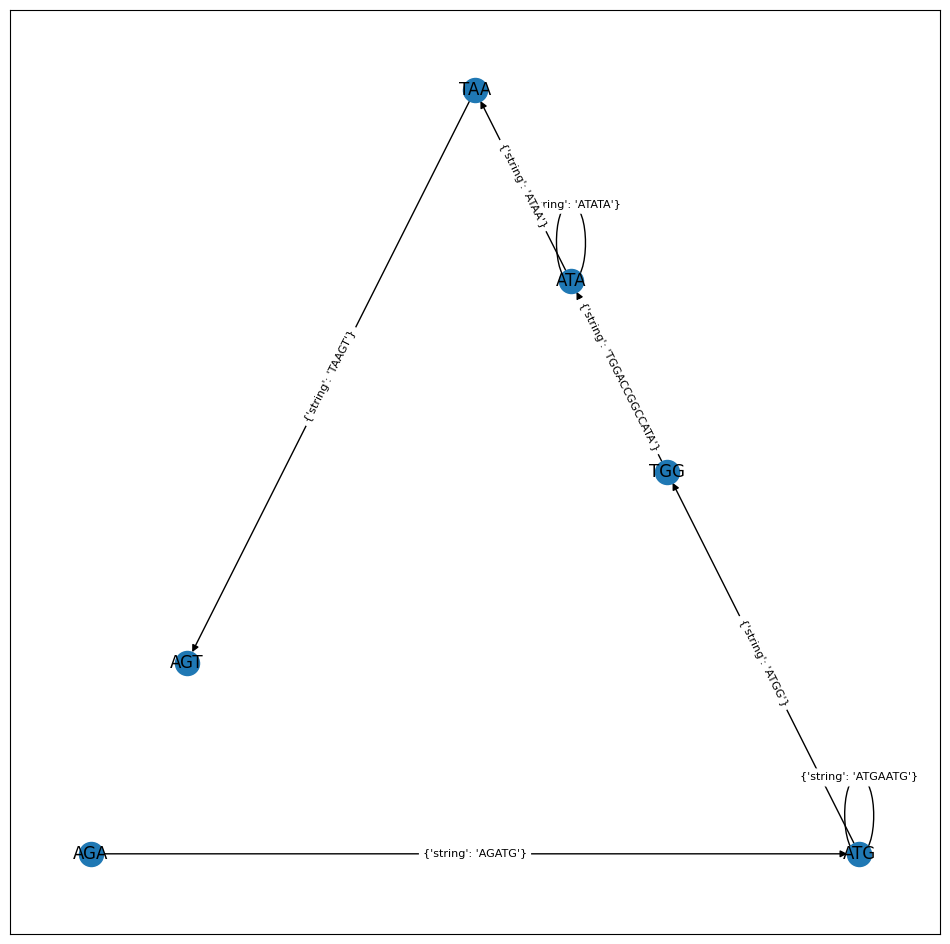

In [203]:
from collections import defaultdict
from copy import deepcopy
import networkx as nx 
import matplotlib.pyplot as plt 


class Node():
    def __init__(self, string):
        self.string = string
        self.in_degree = 0
        self.out_degree = 0
        self.is_compacted = False

class Edge():
    def __init__(self, prev_node, next_node, string, coverage=1):
        self.prev_node = prev_node
        self.next_node = next_node
        self.string = string
        self.coverage = coverage

class DBGraph():
    def __init__(self, reads, k):
        self.reads = reads
        self.k = k
        self.used_edges = set()
        self.used_nodes = set()
        self.nodes = {}
        self.edges = {}
        self.connections = defaultdict(list)
        self.kmers = []
        self.compacted = False

    def gen_kmers(self):
        for read in self.reads:
            self.kmers.extend([read[i:self.k+i] for i in range(0, len(read)-self.k+1)])

    def create_graph(self):
        for kmer in self.kmers:
            prev_node_str = kmer[:-1]
            if prev_node_str not in self.used_nodes:
                self.nodes[prev_node_str] = Node(prev_node_str)
                self.used_nodes.add(prev_node_str)
            self.nodes[prev_node_str].out_degree += 1

            next_node_str = kmer[1:]
            if next_node_str not in self.used_nodes:
                self.nodes[next_node_str] = Node(next_node_str)
                self.used_nodes.add(next_node_str)
            self.nodes[next_node_str].in_degree += 1

            if kmer in self.used_edges:
                self.edges[kmer].coverage += 1
            else:
                self.used_edges.add(kmer)
                self.edges[kmer] = Edge(prev_node_str, next_node_str, kmer)
                self.connections[prev_node_str].append(self.edges[kmer])

    def compact(self):
        if self.compacted:
            print('This graph has already been compacted')
            return
        self.compacted = True
        for node in self.nodes:
            if not self.nodes[node].is_compacted:
                self.nodes[node].is_compacted = True
                if self.nodes[node].out_degree >= 1:
                    new_edge = self.connections[node][0]
                    next_edge = deepcopy(new_edge)
                    while self.nodes[next_edge.next_node].in_degree == 1 and self.nodes[next_edge.next_node].out_degree > 0:
                        prev_edge = new_edge
                        next_edge = self.connections[prev_edge.next_node][0]
                        new_edge_string = prev_edge.string + next_edge.string[-1]
                        new_edge_coverage = int(len(prev_edge.string)/len(new_edge_string)*prev_edge.coverage + len(next_edge.string)/len(new_edge_string)*next_edge.coverage)
                        self.nodes[prev_edge.next_node].is_compacted = True
                        new_edge = Edge(node, next_edge.next_node, new_edge_string, new_edge_coverage)
                        del self.connections[prev_edge.next_node]
                    self.connections[node][0] = new_edge

    def print_connections(self):
        for node in self.connections:
            print(node)
            print(self.connections[node])
            print()

    def find_euler_path(self, v):
        for edge in self.connections_temp[v]:
            if edge.coverage:
                edge.coverage -= 1
                self.string += edge.string[(self.k-1):]
                self.find_euler_path(edge.next_node)

    def assemble(self):
        start = list(self.nodes.keys())[0]
        for i in self.nodes:
            if self.nodes[i].in_degree < self.nodes[start].in_degree:
                start = self.nodes[i]
        self.connections_temp = deepcopy(self.connections)
        self.string = self.connections[start][0].string[:(self.k-1)]
        self.find_euler_path(start)
        return self.string
    
    def visualize(self):
        G = nx.DiGraph() 
        for node in self.connections:
            for edge in self.connections[node]:
                G.add_edge(edge.prev_node, edge.next_node, string=edge.string)
        pos = nx.planar_layout(G)
        plt.figure(figsize=(12,12))
        nx.draw_networkx(G, pos)
        nx.draw_networkx_edge_labels(G, pos, font_size=8)
        plt.show() 

        

true_seq_1 = 'AGATGAATGGACCGGCCATATAAGT'


G = DBGraph([true_seq_1], 4)
G.gen_kmers()
G.create_graph()
s1 = true_seq_1
s2 = G.assemble()
print(s1)
print(s2)
# G.print_connections()
print()
G.visualize()
G.compact()
G.print_connections()
s1_new = true_seq_1
s2 = G.assemble()
print(s1)
print(s2)


G.visualize()

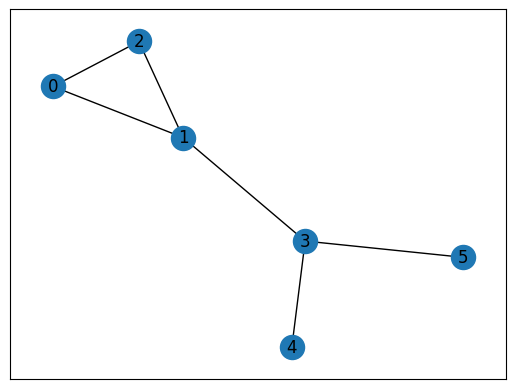

In [49]:
# First networkx library is imported 
# along with matplotlib 
import networkx as nx 
import matplotlib.pyplot as plt 


# Defining a Class 
class GraphVisualization: 

	def __init__(self): 
		
		# visual is a list which stores all 
		# the set of edges that constitutes a 
		# graph 
		self.visual = [] 
		
	# addEdge function inputs the vertices of an 
	# edge and appends it to the visual list 
	def addEdge(self, a, b): 
		temp = [a, b] 
		self.visual.append(temp) 
		
	# In visualize function G is an object of 
	# class Graph given by networkx G.add_edges_from(visual) 
	# creates a graph with a given list 
	# nx.draw_networkx(G) - plots the graph 
	# plt.show() - displays the graph 
	def visualize(self): 
		G = nx.Graph() 
		G.add_edges_from(self.visual) 
		nx.draw_networkx(G) 
		plt.show() 

# Driver code 
G = GraphVisualization() 
G.addEdge(0, 2) 
G.addEdge(1, 2) 
G.addEdge(1, 3) 
G.addEdge(5, 3) 
G.addEdge(3, 4) 
G.addEdge(1, 0) 
G.visualize() 


In [8]:
def shared_motif(seq):
    s_seq = seq[0]
    motif = set()
    for i in range(len(s_seq)):
        for j in range(i+1,len(s_seq)+1):
            motif.add(s_seq[i:j])
    for s in seq:
        update_motif = list(motif)
        for m in update_motif:
            if m not in s:
                motif.remove(m)
    n = 0
    longest_motif = ''
    for i in motif:
        if len(i) > n:
            longest_motif = i
            n = len(i)
    return longest_motif

shared_motif([s1, s2])

'GACCGGCCATATA'

## Сжатие графа  
Научитесь производить сжатие графа Де Брюина. При сжатии не забывайте склеивать подстроки на ребрах и обновлять покрытие ребер. Пересчитывайте покрытие склеиваемых ребер как взвешенное среднее, где вес соответствует длине подстроки, соответствующей ребру.